# Downloading data

In [ ]:
!git clone https://github.com/dialogue-evaluation/RuREBus.git

In [22]:
import os

os.makedirs('./data/train/', exist_ok=True)
os.makedirs('./data/test/', exist_ok=True)
os.makedirs('./data/pred/', exist_ok=True)
os.makedirs('./model/', exist_ok=True)

In [ ]:
!unzip -q -j './RuREBus/train_data/*.zip' -d './data/train'
!unzip -q -j './RuREBus/test_data/test_ner_only.zip' -d './data/test'

In [ ]:
!pip install navec
!pip install numpy==1.23.5
!pip install nltk==3.8.1

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

### Restart Kernel

In [1]:
from tqdm import tqdm
import glob
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate
from keras.initializers import RandomUniform
from nltk.tokenize import NLTKWordTokenizer
from navec import Navec

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = './navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [3]:
wordEmbeddings = []
for word in navec.vocab.words:
    wordEmbeddings.append(navec[word])
wordEmbeddings = np.array(wordEmbeddings)

# BreatDoc and f1_score from RuREBus

In [4]:
import codecs
import bisect
import os


class BratDoc:
    def __init__(self, data):
        self.txt_data = data # Str
        self.relations = [] # List[Tuple[str, int, int]]
        self.ners = [] # List[Tuple[str, int, int]]

        self.rel_id_2_idx = dict()
        self.ner_id_2_idx = dict()

    def add_relation(self, rel_id, reltype, start_idx, end_idx):
        rel_idx = len(self.relations)
        self.rel_id_2_idx[rel_id] = rel_idx
        self.relations.append((reltype, start_idx, end_idx))

    def add_ner(self, ner_id, ner_type, head_l, head_r):
        ner_idx = len(self.ners)
        self.ner_id_2_idx[ner_id] = ner_idx
        self.ners.append((ner_type, head_l, head_r))

    def write_to_file(self, path):
        with codecs.open(path[:-3] + "txt", "w+", encoding="utf-8") as txt_out:
            txt_out.write(self.txt_data)

        with codecs.open(path, "w+", encoding="utf-8") as ann_out:
            for num, idx in self.ner_id_2_idx.items():
                ann_out.write("T{}\t{} {} {}\t{}\n".format(
                    num,
                    self.ners[idx][0],
                    self.ners[idx][1],
                    self.ners[idx][2],
                    self.txt_data[self.ners[idx][1]:self.ners[idx][2]].lstrip(),
                ))

            for num, idx in self.rel_id_2_idx.items():
                left_op = self.ner_id_2_idx[self.relations[idx][1]]
                right_op = self.ner_id_2_idx[self.relations[idx][2]]
                if '\n' in self.txt_data[self.ners[left_op][1]:self.ners[right_op][2]]:
                    continue
                ann_out.write("R{}\t{} Arg1:T{} Arg2:T{}\n".format(
                    num,
                    self.relations[idx][0],
                    self.relations[idx][1],
                    self.relations[idx][2],
                ))


def read_file(path, win_file=True):
    """
    :param path: "path/to/file.ann"
    :param win_file: \r\n counted in markup
    :return:
    """
    data = []
    with codecs.open(path, encoding="utf-8") as f_in:
        data = f_in.readlines()

    pure_txt = ""
    if os.path.exists(path[:-3] + "txt"):
        with codecs.open(path[:-3] + "txt", encoding="utf-8") as f_in:
            pure_txt = f_in.read()

    ignored = dict()

    brat_doc = BratDoc(pure_txt)
    ner_list = []
    for line_num, line in enumerate(data):
        line = line.strip()
        if line.startswith("T"):
            # NER
            try:
                arr = line.split('\t')
                ner_id = arr[0]
                ner = arr[1]
            except:
                print("Invalid relation format")
            if len(ner.split()) != 3:
                ner_id = int(ner_id[1:])
                if ner_id in ignored:
                    ignored[ner_id].append(ner_id)
                else:
                    ignored[ner_id] = [ner_id]
                continue
            nertype, start_idx, end_idx = ner.split()

            ner_id = int(ner_id[1:])
            start_idx = int(start_idx)
            end_idx = int(end_idx)

            ner_list.append((ner_id, nertype, start_idx, end_idx))

    ner_list.sort(key=lambda x: x[2])
    for (ner_id, nertype, start_idx, end_idx) in ner_list:
        brat_doc.add_ner(ner_id, nertype, start_idx, end_idx)

    for line_num, line in enumerate(data):
        line = line.strip()
        if line.startswith("R"):
            # Relation
            rel_id, rel = line.split('\t')
            reltype, arg1, arg2 = rel.split()

            rel_id = int(rel_id[1:])
            head_l = int(arg1[6:])
            head_r = int(arg2[6:])

            if head_l in ignored:
                if head_l in ignored[head_l]:
                    continue

            if head_r in ignored:
                if head_r in ignored[head_r]:
                    continue

            brat_doc.add_relation(rel_id, reltype, head_l, head_r)

    return brat_doc


In [5]:
import sys

import os

def compute_precision_and_recall(true_positive, false_positive, false_negative):
    """
    Вычисляем точность и полноту по TP, FP и FN
    """
    if false_positive + true_positive > 0:
        precision = float(true_positive) / (true_positive + false_positive)
    else:
        precision = 0
    if false_negative + true_positive > 0:
        recall = float(true_positive) / (true_positive + false_negative)
    else:
        recall = 0
    return recall, precision


def cacl_ner_tp_fp_fn(true_ners, pred_ners):
    
    true_positive = 0
    false_positive = 0
    false_negative = 0

    i = 0
    j = 0
    while i != len(true_ners) and j != len(pred_ners):
        if true_ners[i] == pred_ners[j]:
            true_positive += 1
            i += 1
            j += 1
            continue
        if true_ners[i][1] >= pred_ners[j][2]:
            false_positive += 1
            j += 1
            continue
        if true_ners[i][2] <= pred_ners[j][1]:
            false_negative += 1
            i += 1
            continue
        if true_ners[i][1] < pred_ners[j][1]:
            false_negative += 1
            i += 1
            continue
        if true_ners[i][1] > pred_ners[j][1]:
            false_positive += 1
            j += 1
            continue

        false_positive += 1
        false_negative += 1
        j += 1
        i += 1

    false_negative += len(true_ners) - i
    false_positive += len(pred_ners) - j

    return true_positive, false_positive, false_negative



def calc_ner_f1(true_dir, pred_dir):
    total_tp = 0
    total_fp = 0
    total_fn = 0

    files = os.listdir(true_dir)

    for doc in files:
        if doc.endswith(".ann"):
            true_doc = os.path.join(true_dir, doc)
            pred_doc = os.path.join(pred_dir, doc)


            true_data = read_file(true_doc)
            true_ners = sorted(true_data.ners, key=lambda x: x[1])

            pred_ners = []
            if os.path.exists(pred_doc):
                try:
                    pred_data = read_file(pred_doc)
                    pred_ners = sorted(pred_data.ners, key=lambda x: x[1])
                except:
                    pass

            tp, fp, fn = cacl_ner_tp_fp_fn(true_ners, pred_ners)
            
            total_tp += tp
            total_fp += fp
            total_fn += fn

    precision, recall = compute_precision_and_recall(total_tp, total_fp, total_fn)

    f_measure = 2 * precision * recall / (precision + recall)
    
    return f_measure

# Data to encode

In [6]:
labelSet  = {"OUT":0, "ACT":1, "BIN":2, "CMP":3, "ECO":4, "INST":5, "MET":6, "SOC":7, "QUA":8, "O":9 }

case2Idx = {'numeric': 0, 'allLower':1, 'allUpper':2, 'initialUpper':3, 'other':4, 'mainly_numeric':5, 'contains_digit': 6, 'PADDING_TOKEN':7}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')

char2Idx = {"PADDING":0, "UNKNOWN":1}

pure_txt = ''
for fl_pth in  glob.glob('./data/train/*.txt') + glob.glob('./data/test/*.txt'):
        with codecs.open(fl_pth, encoding="utf-8") as f_in:
            pure_txt += f_in.read() 
for label in set(pure_txt):
    char2Idx[label] = len(char2Idx)

In [7]:
import nltk
nltk.download('punkt')
def tknz(s):
    return [token.replace("''", '"').replace("``", '"') for token in nltk.word_tokenize(s, language="russian")]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
#[['Государственная', 'O'], ['программа','O'], ['Курганской', 'LOC'], ...]
def word_lab_format(txt_data, ners, def_ner = "O"):
    word_data = []

    prev = 0
    for labl, l, r in ners:
        unlabld_tokens = tknz(txt_data[prev:l])
        if len(unlabld_tokens) != 0:
            word_data.append([[token, def_ner] for token in unlabld_tokens])
        labld_tokens = tknz(txt_data[l:r])
        word_data.append([[token, labl] for token in labld_tokens])
        prev = r
    return sum(word_data, [])

In [9]:
def getCasing(word):   
    casing = 'other'
    
    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1
            
    digitFraction = numDigits / float(len(word))
    
    if word.isdigit(): #Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower(): #All lower case
        casing = 'allLower'
    elif word.isupper(): #All upper case
        casing = 'allUpper'
    elif word[0].isupper(): #is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'  
    return case2Idx[casing]

def to_vec(data, train=True):
    data_vec = []
    for token_data in data:
        token = token_data[0]
        token_chars = list(str(token))
        #ner_label = token_data[1]

        chrs = list(str(token))
        w_vec = navec.get(token, navec.get(token.lower(), navec['<unk>']))
        case_vec = getCasing(token)
        char_vec = [char2Idx.get(ch, char2Idx['UNKNOWN']) for ch in chrs]
        char_vec = pad_sequences([char_vec],64,padding='post')[0]
        if train:
            data_vec.append([w_vec, case_vec, char_vec, labelSet[token_data[1]]])
        else:
            data_vec.append([w_vec, case_vec, char_vec])
    return np.array(data_vec)

# Tokenize and encode text

In [10]:
train_sentences = []
for fl_pth in tqdm(glob.glob('./data/train/*.ann')):
    brat_format = read_file(fl_pth)
    sentences = word_lab_format(brat_format.txt_data, brat_format.ners)
    train_sentences.append(sentences)

train_sentences = sum(train_sentences, [])
train_sentences = np.array(train_sentences)

100%|██████████| 188/188 [00:14<00:00, 13.12it/s]


In [11]:
train_data = to_vec(train_sentences)

/tmp/ipykernel_100/4204118714.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_vec)


# Train batches

In [12]:
def create_batches_indexes(data, min_batch_size=128):
    it = 0
    batches_idxs = []
    while it < len(data):
        it_prev = it
        it += min_batch_size
        if it >= len(data):
            batches_idxs.append([it_prev, len(data)])
            break    
        lbl = data[it-1][3]
        if lbl != len(labelSet)-1:
            while it < len(data) and data[it][3] == lbl:
                it+=1
        batches_idxs.append([it_prev, it])
    return batches_idxs

In [13]:
batches_indexes = create_batches_indexes(train_data)

# Model

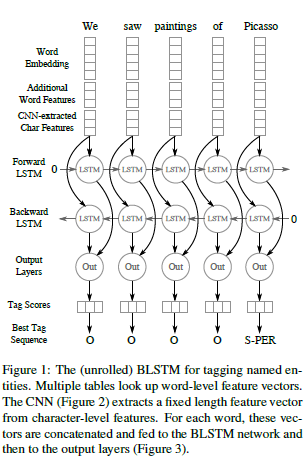
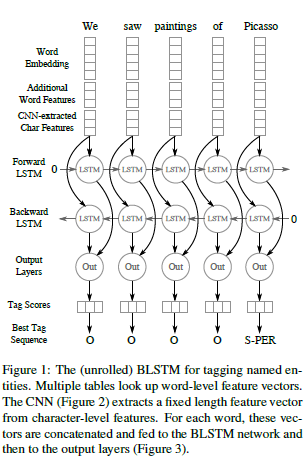

In [14]:
words_input = Input(shape=(None,300,),name='words_input')

casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=caseEmbeddings.shape[1], input_dim=caseEmbeddings.shape[0], weights=[caseEmbeddings], trainable=False)(casing_input)

character_input=Input(shape=(None,64,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char2Idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(64))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

output = concatenate([words_input, casing, char])
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(labelSet), activation='softmax'))(output)
model = Model(inputs=[words_input, casing_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, None, 64)]           0         []                            
                                                                                                  
 char_embedding (TimeDistri  (None, None, 64, 30)         6030      ['char_input[0][0]']          
 buted)                                                                                           
                                                                                                  
 dropout (Dropout)           (None, None, 64, 30)         0         ['char_embedding[0][0]']      
                                                                                                  
 time_distributed (TimeDist  (None, None, 64, 30)         2730      ['dropout[0][0]']         

In [15]:
def get_spans(txt, test_words):
    spans = list(NLTKWordTokenizer().span_tokenize(txt))
    res_spans = []
    span_it = 0
    l,r=0,0
    for w in test_words:
        assert(l <= r)
        if l == r:
            l,r = spans[span_it][0], spans[span_it][1]
            span_it+=1
        res_spans.append([l, l+len(w)])
        l+=len(w)
    return res_spans

def annot_format(pred_anns, spans):
    assert(len(pred_anns) == len(spans))
    ann_lines = []
    prev_ann = None
    for i, (_,ann) in enumerate(pred_anns):
        if prev_ann != ann:
            ann_lines.append([spans[i],ann])
            prev_ann = ann
        else:
            ann_lines[-1][0][1]=spans[i][1]
    return ann_lines

def write_ann(pure_txt, ann_lines, path):
    with codecs.open(path[:-3]+'ann', "w+", encoding="utf-8") as ann_out:
        ctr = 1
        for lr, ann in ann_lines:
            if ann == 'O': continue
            l, r = lr
            ann_out.write("T{}\t{} {} {}\n".format(
                ctr, ann, l, r
            ))
            ctr+=1

def pred_ann(txt_path, ann_dir='pred'):
    pure_txt = ""
    if os.path.exists(txt_path):
        with codecs.open(txt_path, encoding="utf-8") as f_in:
            pure_txt = f_in.read()
    test_words = tknz(pure_txt)
    test_vec = to_vec(np.array(test_words).reshape(-1,1),train=False)

    tokens_b, casing_b, char_b = test_vec.T
    tokens_b, casing_b, char_b = np.stack(tokens_b), np.stack(casing_b), np.stack(char_b)
    tokens_b, casing_b, char_b = tokens_b.reshape(1,-1,300), casing_b.reshape(1,-1), char_b.reshape(1,-1,64)       
    
    pred = model.predict([tokens_b, casing_b, char_b], verbose=0)[0]
    pred = pred.argmax(axis=-1)
    idx2Label = np.array(list(labelSet))
    pred = [idx2Label[x].strip() for x in pred]
    pred_token_anns = list(zip(test_words,pred))

    spans = get_spans(pure_txt, test_words)

    ann_path = txt_path.split('/')
    ann_path[-2] = ann_dir
    ann_path ='/'.join(ann_path)

    write_ann(pure_txt,
              annot_format(pred_token_anns, spans),
              ann_path)

In [16]:
epochs = 20

In [17]:
losses = []
scores = []

# Training loop

In [18]:
for epoch in range(epochs):
    for l, r in tqdm(batches_indexes, desc='Train epoch '+str(epoch)):
        b_losses = []
        batch = train_data[l:r]
        tokens_b, casing_b, char_b, labels_b = batch.T
        tokens_b, casing_b, char_b, labels_b = np.stack(tokens_b), np.stack(casing_b), np.stack(char_b), np.stack(labels_b)
        labels_b, tokens_b, casing_b, char_b = labels_b.reshape(1,-1,1), tokens_b.reshape(1,-1,300), casing_b.reshape(1,-1), char_b.reshape(1,-1,64)       
        b_losses.append(model.train_on_batch([tokens_b, casing_b, char_b], labels_b))

    for to_ann_path in tqdm(glob.glob('./data/test/*.txt'), desc='Testing'):
        pred_ann(to_ann_path)

    losses.append(np.array(b_losses).mean())
    scores.append(calc_ner_f1('./data/test/', './data/pred/'))
    print(f'loss: {losses[-1]}\tscore: {scores[-1]}')

Testing:   0%|          | 0/544 [00:00<?, ?it/s]/tmp/ipykernel_100/4204118714.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_vec)
Testing: 100%|██████████| 544/544 [07:07<00:00,  1.27it/s]


loss: 0.3384000062942505	score: 0.31946295020037263


Testing: 100%|██████████| 544/544 [06:05<00:00,  1.49it/s]


loss: 0.21275173127651215	score: 0.3268941746989159


Testing: 100%|██████████| 544/544 [06:09<00:00,  1.47it/s]


loss: 0.2312711626291275	score: 0.32657911819044294


Testing: 100%|██████████| 544/544 [06:05<00:00,  1.49it/s]


loss: 0.24148593842983246	score: 0.32824563840978105


Testing: 100%|██████████| 544/544 [05:59<00:00,  1.51it/s]


loss: 0.17054195702075958	score: 0.32635411248978374


Testing: 100%|██████████| 544/544 [06:01<00:00,  1.51it/s]


loss: 0.2813318073749542	score: 0.3249682764798089


Testing: 100%|██████████| 544/544 [05:59<00:00,  1.52it/s]


loss: 0.17749187350273132	score: 0.3192627260991572


Testing: 100%|██████████| 544/544 [06:00<00:00,  1.51it/s]


loss: 0.13477161526679993	score: 0.3194096836951492


Testing: 100%|██████████| 544/544 [05:58<00:00,  1.52it/s]


loss: 0.13059453666210175	score: 0.32036581287034316


Testing: 100%|██████████| 544/544 [05:58<00:00,  1.52it/s]


loss: 0.1396006941795349	score: 0.3205359494664857


Testing: 100%|██████████| 544/544 [05:58<00:00,  1.52it/s]


loss: 0.13861577212810516	score: 0.3203695959535615


Testing: 100%|██████████| 544/544 [06:06<00:00,  1.48it/s]


loss: 0.12490076571702957	score: 0.32285340535486023


Testing: 100%|██████████| 544/544 [06:02<00:00,  1.50it/s]


loss: 0.11607395857572556	score: 0.3222476545010941


Testing: 100%|██████████| 544/544 [06:02<00:00,  1.50it/s]


loss: 0.16409364342689514	score: 0.3177815626357929


Testing: 100%|██████████| 544/544 [06:01<00:00,  1.50it/s]


loss: 0.09878793358802795	score: 0.3169451408383749


Testing: 100%|██████████| 544/544 [06:02<00:00,  1.50it/s]


loss: 0.1259656399488449	score: 0.32004011771916585


Testing: 100%|██████████| 544/544 [06:02<00:00,  1.50it/s]


loss: 0.14094580709934235	score: 0.31515229955148916


Testing: 100%|██████████| 544/544 [05:59<00:00,  1.51it/s]


loss: 0.13454921543598175	score: 0.32045397479033794


Testing: 100%|██████████| 544/544 [06:01<00:00,  1.50it/s]


loss: 0.15444833040237427	score: 0.31618263891663


Train epoch 19:   7%|▋         | 164/2523 [01:04<15:31,  2.53it/s]


KeyboardInterrupt: 

# Results

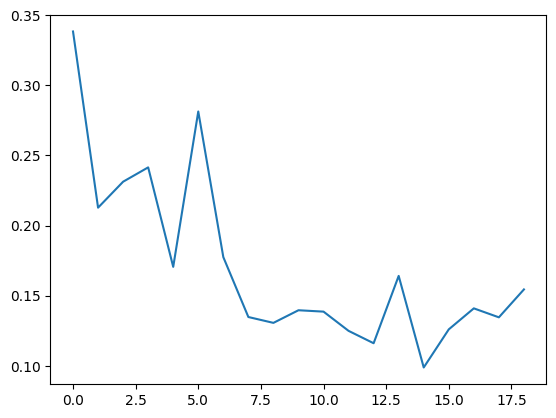

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)

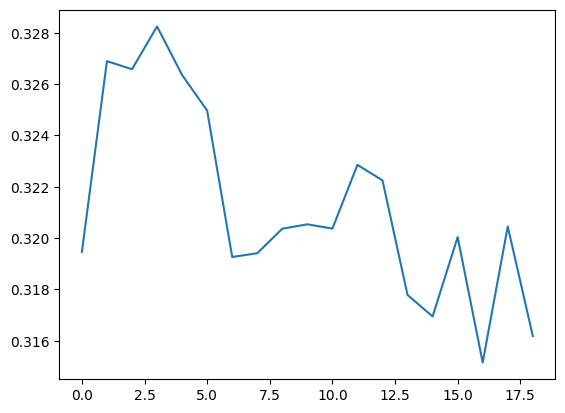

In [21]:
plt.plot(scores)

In [23]:
model.save('./model/CNN_LSTM.keras')

In [19]:
losses, scores

([0.3384000062942505,
  0.21275173127651215,
  0.2312711626291275,
  0.24148593842983246,
  0.17054195702075958,
  0.2813318073749542,
  0.17749187350273132,
  0.13477161526679993,
  0.13059453666210175,
  0.1396006941795349,
  0.13861577212810516,
  0.12490076571702957,
  0.11607395857572556,
  0.16409364342689514,
  0.09878793358802795,
  0.1259656399488449,
  0.14094580709934235,
  0.13454921543598175,
  0.15444833040237427],
 [0.31946295020037263,
  0.3268941746989159,
  0.32657911819044294,
  0.32824563840978105,
  0.32635411248978374,
  0.3249682764798089,
  0.3192627260991572,
  0.3194096836951492,
  0.32036581287034316,
  0.3205359494664857,
  0.3203695959535615,
  0.32285340535486023,
  0.3222476545010941,
  0.3177815626357929,
  0.3169451408383749,
  0.32004011771916585,
  0.31515229955148916,
  0.32045397479033794,
  0.31618263891663])